In [1]:
import theano
theano.config.exception_verbosity='high'
theano.config.mode='DebugMode'
import pymc3 as pm

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns
sns.set_style("ticks")
sns.set_context("poster")

In [2]:
disaster_data = np.ma.masked_values(np.array([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                            3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                            2, 2, 3, 4, 2, 1, 3, -999, 2, 1, 1, 1, 1, 3, 0, 0,
                            1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                            0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                            3, 3, 1, -999, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                            0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1], dtype=np.int64), value=-999,)
year = np.arange(1851, 1962)

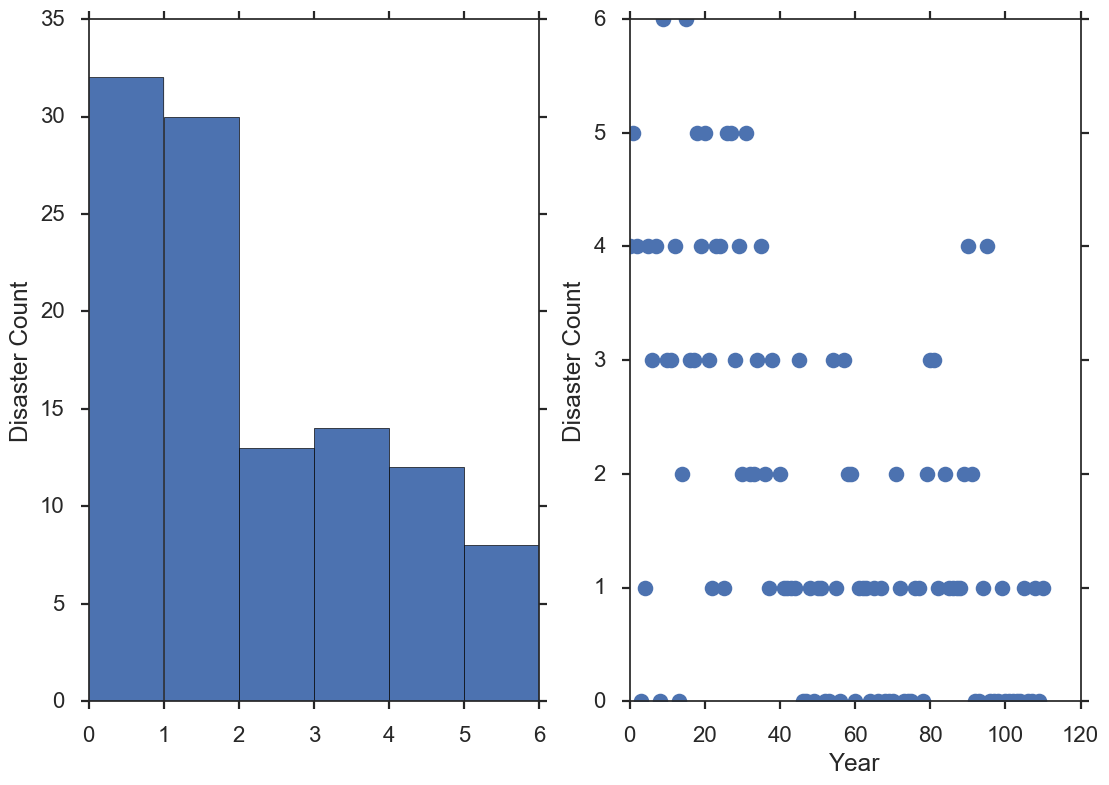

In [3]:
fig, ax = plt.subplots(1,2)

ax[0].hist(disaster_data, bins=range(disaster_data.max() + 1))
ax[1].plot(disaster_data, "o")
ax[1].set_xlabel("Year")
ax[1].set_ylabel("Disaster Count")
ax[0].set_ylabel("Disaster Count")

In [4]:
disaster_data

masked_array(data = [4L 5L 4L 0L 1L 4L 3L 4L 0L 6L 3L 3L 4L 0L 2L 6L 3L 3L 5L 4L 5L 3L 1L 4L 4L
 1L 5L 5L 3L 4L 2L 5L 2L 2L 3L 4L 2L 1L 3L -- 2L 1L 1L 1L 1L 3L 0L 0L 1L 0L
 1L 1L 0L 0L 3L 1L 0L 3L 2L 2L 0L 1L 1L 1L 0L 1L 0L 1L 0L 0L 0L 2L 1L 0L 0L
 0L 1L 1L 0L 2L 3L 3L 1L -- 2L 1L 1L 1L 1L 2L 4L 2L 0L 0L 1L 4L 0L 0L 0L 1L
 0L 0L 0L 0L 0L 1L 0L 0L 1L 0L 1L],
             mask = [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False  True
 False False False False False False False False False False False False
 False False False False False False

In [5]:
year

array([1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1859, 1860, 1861,
       1862, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 1870, 1871, 1872,
       1873, 1874, 1875, 1876, 1877, 1878, 1879, 1880, 1881, 1882, 1883,
       1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893, 1894,
       1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905,
       1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915, 1916,
       1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949,
       1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960,
       1961])

In [7]:
with pm.Model() as disaster_model:

    switchpoint = pm.DiscreteUniform('switchpoint', lower=year.min(), upper=year.max(), testval=1900)

    # Priors for pre- and post-switch rates number of disasters
    early_rate = pm.Exponential('early_rate', 1)
    late_rate = pm.Exponential('late_rate', 1)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= year, early_rate, late_rate)
    

    disasters = pm.Poisson('disasters', rate, observed=disaster_data)

In [8]:
with disaster_model:
    step1 = pm.NUTS([early_rate, late_rate])

    # Use Metropolis for switchpoint, and missing values since it accommodates discrete variables
    step2 = pm.Metropolis([switchpoint, disasters.missing_values[0]] )

    trace = pm.sample(10000, step=[step1, step2])

InvalidValueError: InvalidValueError
        type(variable) = TensorType(float32, scalar)
        variable       = TensorConstant{-inf}
        type(value)    = <type 'numpy.ndarray'>
        dtype(value)   = float32
        shape(value)   = ()
        value          = -inf
        min(value)     = -inf
        max(value)     = -inf
        isfinite       = False
        client_node    = None
        hint           = Graph Input 'TensorConstant{-inf}' has invalid value -inf
        specific_hint  = none
        context        = ...
  TensorConstant{-inf} [id A]

        

In [9]:
with disaster_model:
    trace = pm.sample(100)

Assigned Metropolis to switchpoint
Assigned NUTS to early_rate_log_
Assigned NUTS to late_rate_log_
Assigned Metropolis to disasters_missing


InvalidValueError: InvalidValueError
        type(variable) = TensorType(float32, scalar)
        variable       = TensorConstant{-inf}
        type(value)    = <type 'numpy.ndarray'>
        dtype(value)   = float32
        shape(value)   = ()
        value          = -inf
        min(value)     = -inf
        max(value)     = -inf
        isfinite       = False
        client_node    = None
        hint           = Graph Input 'TensorConstant{-inf}' has invalid value -inf
        specific_hint  = none
        context        = ...
  TensorConstant{-inf} [id A]

        